## 5.3 利用季節等週期性預測銷售額（時間序列分析）

### 共通事前處理

In [34]:
# 取得中文字型
!wget 'https://github.com/flyingpath/electron-hand-dicom/raw/master/TaipeiSansTCBeta-Regular.ttf'

--2021-12-09 05:47:31--  https://github.com/flyingpath/electron-hand-dicom/raw/master/TaipeiSansTCBeta-Regular.ttf
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/flyingpath/electron-hand-dicom/master/TaipeiSansTCBeta-Regular.ttf [following]
--2021-12-09 05:47:31--  https://raw.githubusercontent.com/flyingpath/electron-hand-dicom/master/TaipeiSansTCBeta-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf.1’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.1s    

2021-12-09 05:47:3

In [35]:
# 共通事前處理

# 隱藏不必要的警告
import warnings
warnings.filterwarnings('ignore')

# 匯入必要的函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 將字型新增到 matplotlib
fm.fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')

# 用來顯示資料框的函式
from IPython.display import display

# 調整顯示選項
# NumPy 的浮點數表示精度
np.set_printoptions(suppress=True, precision=4)

# pandas 中的浮點數表示精度
pd.options.display.float_format = '{:.4f}'.format

# 顯示資料框中的所有項目
pd.set_option("display.max_columns",None)

# 指定圖形的預設字體大小
plt.rcParams["font.size"] = 14

# 指定圖形的預設字型
plt.rcParams['font.family'] = 'Taipei Sans TC Beta'

# 隨機種子
random_seed = 123

原始連結  
https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

#### 資料項目備忘錄

instant　索引  
dteday　日期　（yy-mm-dd）  
season　季節　（1: 冬 2: 春 3: 夏 4: 秋）  
yr　年份　（0: 2011, 1:2012）  
mnth　月份 （1 - 12）  
hr　小時 （0 - 23）  
holiday　國定假日  
weekday　星期幾　（0 - 6）  
workingday　工作日　（1: 工作日 0: 假日）  
weathersit　天氣　（1: 晴到多雲 2: 有霧 3: 小雨 4: 大雨）  
temp　氣溫 （已正規化）  
atemp　體感溫度　（已正規化）  
hum　濕度　（已正規化）  
windspeed　風速　（已正規化）  
casual　臨時用戶租借量  
registered　註冊用戶租借量  
cnt　整體用戶租借量  

### 5.3.4 從載入資料到確認資料

#### 載入資料

In [36]:
# 下載網址
url = 'https://archive.ics.uci.edu/ml/\
machine-learning-databases/00275/\
Bike-Sharing-Dataset.zip'

# 下載並解壓縮公開資料集
!wget $url -O Bike-Sharing-Dataset.zip | tail -n 1
!unzip -o Bike-Sharing-Dataset.zip | tail -n 1

--2021-12-09 05:47:32--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K  1004KB/s    in 0.3s    

2021-12-09 05:47:32 (1004 KB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]

  inflating: hour.csv                


In [37]:
# 將 day.csv 匯入資料框
# 由 parse_dates 指定代表日期的行
df = pd.read_csv('day.csv', parse_dates=[1])

In [38]:
# instant 為連號，不需預測，因此刪除
df = df.drop('instant', axis=1)

# 將項目名稱替換成中文

columns = [
    '日期',  '季節',  '年份', '月份', '國定假日', '星期幾', '工作日', '天氣', 
    '氣溫', '體感溫度',  '濕度', '風速',
    '臨時用戶租借量', '註冊用戶租借量', '整體用戶租借量'
]

# 將項目名稱替換成中文
df.columns = columns

#### 確認資料

In [39]:
# 確認開頭 5 列
display(df.head())

# 確認結尾 5 列
display(df.tail())

,日期,季節,年份,月份,國定假日,星期幾,工作日,天氣,氣溫,體感溫度,濕度,風速,臨時用戶租借量,註冊用戶租借量,整體用戶租借量
0,2011-01-01,1,0,1,0,6,0,2,0.3442,0.3636,0.8058,0.1604,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.3635,0.3537,0.6961,0.2485,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.1964,0.1894,0.4373,0.2483,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.2000,0.2121,0.5904,0.1603,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.2270,0.2293,0.4370,0.1869,82,1518,1600


,日期,季節,年份,月份,國定假日,星期幾,工作日,天氣,氣溫,體感溫度,濕度,風速,臨時用戶租借量,註冊用戶租借量,整體用戶租借量
726,2012-12-27,1,1,12,0,4,1,2,0.2542,0.2266,0.6529,0.3501,247,1867,2114
727,2012-12-28,1,1,12,0,5,1,2,0.2533,0.2550,0.5900,0.1555,644,2451,3095
728,2012-12-29,1,1,12,0,6,0,2,0.2533,0.2424,0.7529,0.1244,159,1182,1341
729,2012-12-30,1,1,12,0,0,0,1,0.2558,0.2317,0.4833,0.3508,364,1432,1796
730,2012-12-31,1,1,12,0,1,1,2,0.2158,0.2235,0.5775,0.1548,439,2290,2729


### 5.3.5 預處理資料與分割資料

#### 預處理資料
替換行名以便使用 Prophet

In [40]:
# 只提取「日期」與「註冊用戶租借量」
# 以「日期：ds、註冊用戶租借量：y」替換行名，建立資料框 df2

# 複製整個資料框
df2 = df.copy()

# 提取「日期」與「註冊用戶租借量」的行
df2 = df2[['日期', '註冊用戶租借量']]

# 替換行名
df2.columns = ['ds', 'y']

# 確認結果
display(df2.head())

,ds,y
0,2011-01-01,654
1,2011-01-02,670
2,2011-01-03,1229
3,2011-01-04,1454
4,2011-01-05,1518


#### 分割資料
以 2012 年 11 月 1 日之前為訓練資料(x_train)，之後為驗證資料(x_test)

In [41]:
# 設定分割日 mday
mday = pd.to_datetime('2012-11-1')

# 建立訓練用 index 與驗證用 index
train_index = df2['ds'] < mday
test_index = df2['ds'] >= mday

# 分割輸入資料
x_train = df2[train_index]
x_test = df2[test_index]

# 分割日期資料（用於繪製圖形）
dates_test = df2['ds'][test_index]

### 5.3.6 選擇演算法

#### 選擇演算法

In [42]:
# 匯入套件
from fbprophet import Prophet

# 選擇模型
# 這 3 個 seasonality 參數的設定很重要
# 本資料為日單位，因此不需使用 daily_seasonality
# weekly_seasonality 與 daily_seasonality 除了 True/False 以外，
# 也可以指定成數值（三角函數的數量）
# seasonality_mode: additive(預設) multiplicative

m1 = Prophet(yearly_seasonality=True, weekly_seasonality=True, 
    daily_seasonality=False,
    seasonality_mode='multiplicative')

### 5.3.7 訓練與預測

#### 訓練

In [43]:
# 訓練
m1.fit(x_train)

#### 預測

In [44]:
# 建立預測用的資料
# （只含有日期 ds 的資料框）
# 61 為欲預測之天數（2012-11-1 到 2012-12-31）
future1 = m1.make_future_dataframe(periods=61, freq='D')

# 確認結果
display(future1.head())
display(future1.tail())

,ds
0,2011-01-01
1,2011-01-02
2,2011-01-03
3,2011-01-04
4,2011-01-05


,ds
726,2012-12-27
727,2012-12-28
728,2012-12-29
729,2012-12-30
730,2012-12-31


In [45]:
# 預測
# 結果會以資料框傳回
fcst1 = m1.predict(future1)

### 5.3.8 評估

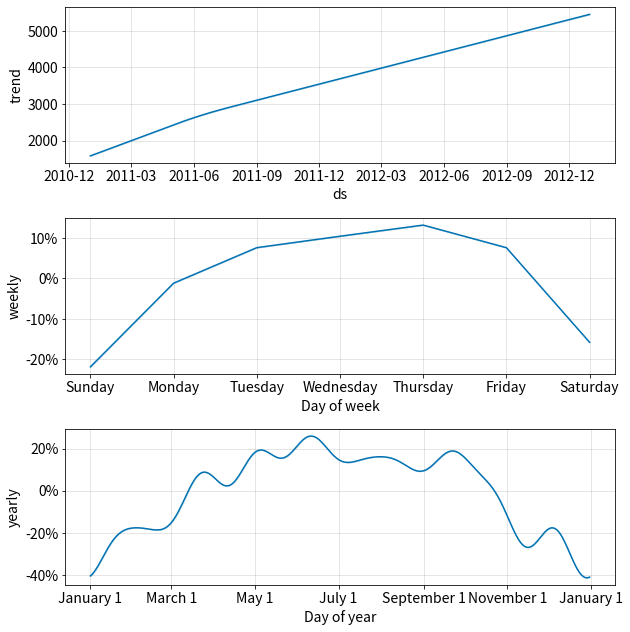

In [46]:
# 繪製各元素的圖形
# 現階段為趨勢、週循環及年循環
fig = m1.plot_components(fcst1)
plt.show()

#### 將整體訓練資料與驗證資料繪製成圖形

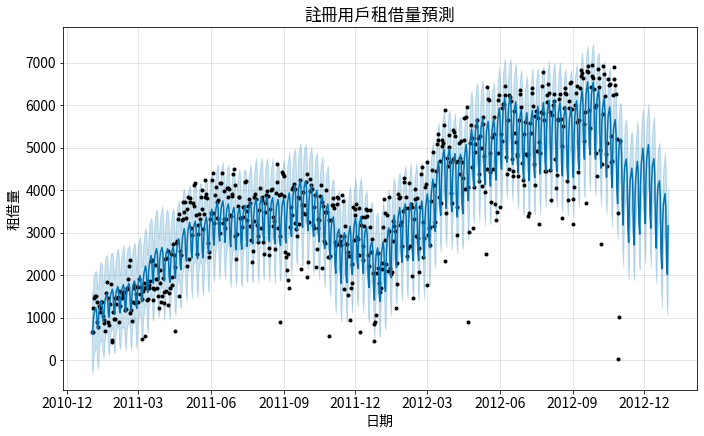

In [47]:
# 將整體訓練資料與驗證資料繪製成圖形
fig, ax = plt.subplots(figsize=(10,6))

# 繪製預測結果的圖形（prophet 的函式）
m1.plot(fcst1, ax=ax)

# 設定標題等
ax.set_title('註冊用戶租借量預測')
ax.set_xlabel('日期')
ax.set_ylabel('租借量')

# 繪製圖形
plt.show()

#### 計算 R2 值

In [48]:
# ypred1：只從 fcst1 中提取預測部分
ypred1 = fcst1[-61:][['yhat']].values

# ytest1：預測期間內的標準答案
ytest1 = x_test['y'].values

# 計算 R2 值
from sklearn.metrics import r2_score
score = r2_score(ytest1, ypred1)

# 確認結果
print(f'R2 score:{score:.4f}')

R2 score:0.3725


#### 繪製驗證期間的圖形（標準答案與預測結果）

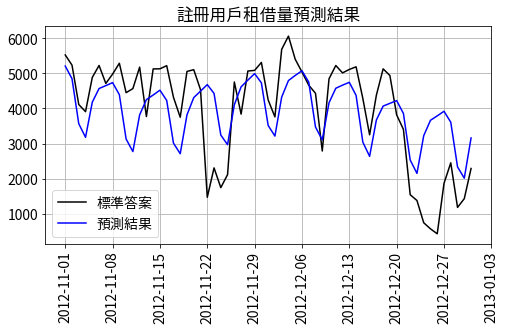

In [49]:
# 繪製時間序列圖
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 4))

# 繪製圖形
ax.plot(dates_test, ytest1, label='標準答案', c='k')
ax.plot(dates_test, ypred1, label='預測結果', c='b')

# 日期刻度間隔
# 於每週四顯示日期
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 將日期刻度標籤文字旋轉 90 度
ax.tick_params(axis='x', rotation=90)

# 顯示網格等
ax.grid()
ax.legend()
ax.set_title('註冊用戶租借量預測結果')

# 輸出畫面
plt.show()

### 調整策略

* 步驟 1 新增「國定假日」為特殊日  
* 步驟 2 新增「天氣」、「氣溫」、「風速」及「濕度」到迴歸模型中


### 5.3.9 調整（步驟 1）

#### 步驟 1
新增「國定假日」為特殊日（holidays）

In [50]:
# 提取國定假日
df_holiday = df[df['國定假日']==1]
holidays = df_holiday['日期'].values

# 轉換為資料框格式
df_add = pd.DataFrame({'holiday': 'holi',
    'ds': holidays,
    'lower_window': 0,
    'upper_window': 0
})

# 確認結果
display(df_add.head())     
display(df_add.tail())                

,holiday,ds,lower_window,upper_window
0,holi,2011-01-17,0,0
1,holi,2011-02-21,0,0
2,holi,2011-04-15,0,0
3,holi,2011-05-30,0,0
4,holi,2011-07-04,0,0


,holiday,ds,lower_window,upper_window
16,holi,2012-09-03,0,0
17,holi,2012-10-08,0,0
18,holi,2012-11-12,0,0
19,holi,2012-11-22,0,0
20,holi,2012-12-25,0,0


In [51]:
# 以國定假日（df_add）為模型輸入

# 選擇演算法
# 新增 holidays 參數並生成模型 m2
m2 = Prophet(yearly_seasonality=True, 
    weekly_seasonality=True, daily_seasonality=False,
    holidays = df_add, seasonality_mode='multiplicative')

# 訓練
m2 = m2.fit(x_train)

# 預測
fcst2 = m2.predict(future1)

#### 步驟 1 的評估

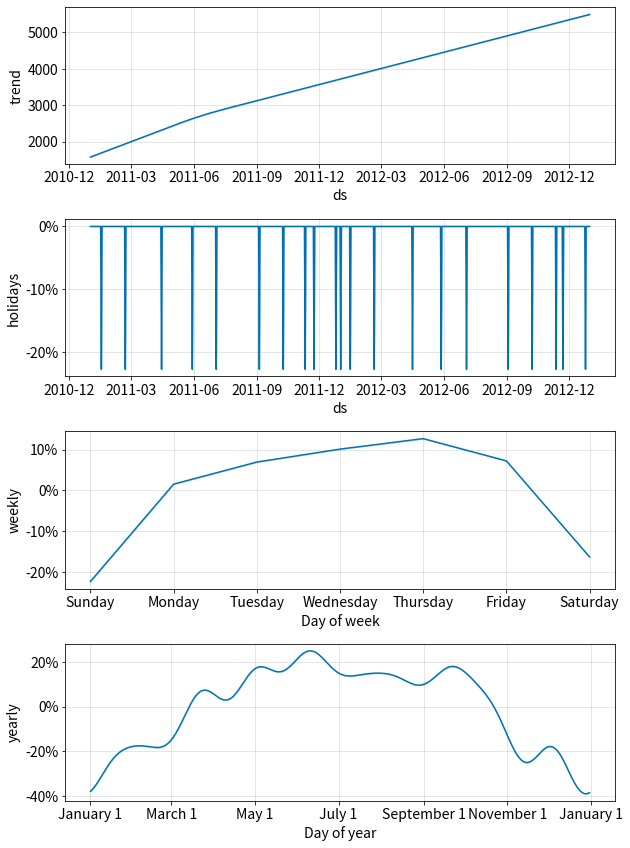

In [52]:
# 繪製各元素的圖形
fig = m2.plot_components(fcst2)
plt.show()

In [53]:
# 計算 R2 值

# 只從 fcst2 中提取預測部分
ypred2 = fcst2[-61:][['yhat']].values

# 計算 R2 值
score2 = r2_score(ytest1, ypred2)

# 確認結果
r2_text2 = f'R2 score:{score2:.4f}'
print(r2_text2)

R2 score:0.4146


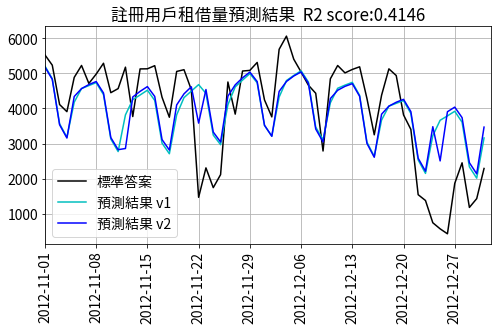

In [54]:
# 繪製時間序列圖
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 4))

# 繪製圖形
ax.plot(dates_test, ytest1, label='標準答案', c='k')
ax.plot(dates_test, ypred1, label='預測結果 v1', c='c')
ax.plot(dates_test, ypred2, label='預測結果 v2', c='b')

# 日期刻度間隔
# 於每週四顯示日期
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 將日期刻度標籤文字旋轉 90 度
ax.tick_params(axis='x', rotation=90)

# 開始日與結束日
sday = pd.to_datetime('2012-11-1')
eday = pd.to_datetime('2013-1-1')
ax.set_xlim(sday, eday) 

# 顯示網格等
ax.grid()
ax.legend()
ax.set_title('註冊用戶租借量預測結果  ' + r2_text2)

# 輸出畫面
plt.show()

### 5.3.10 調整（步驟 2）
將「天氣」、「氣溫」、「風速」及「濕度」納入預測模型

In [55]:
# 在訓練資料中新增「天氣」、「氣溫」、「風速」及「濕度」
df3 = pd.concat([df2, df[['天氣', '氣溫', '風速', '濕度']]], axis=1)

# 分割輸入資料
x2_train = df3[train_index]
x2_test = df3[test_index]

# 確認結果
display(x2_train.tail())

,ds,y,天氣,氣溫,風速,濕度
665,2012-10-27,5209,2,0.5300,0.2357,0.7200
666,2012-10-28,3461,2,0.4775,0.3980,0.6946
667,2012-10-29,20,3,0.4400,0.3582,0.8800
668,2012-10-30,1009,2,0.3182,0.2130,0.8255
669,2012-10-31,5147,2,0.3575,0.1667,0.6667


In [56]:
# 選擇演算法

m3 = Prophet(yearly_seasonality=True, 
    weekly_seasonality=True, daily_seasonality=False,
    seasonality_mode='multiplicative', holidays = df_add)

# 利用 add_regressor 函式將「天氣」、「氣溫」、「風速」及「濕度」納入模型中
m3.add_regressor('天氣')
m3.add_regressor('氣溫')
m3.add_regressor('風速')
m3.add_regressor('濕度')

# 訓練
m3.fit(x2_train)

In [57]:
# 建立預測用的輸入資料
future3 = df3[['ds', '天氣', '氣溫', '風速', '濕度']]

# 預測
fcst3 = m3.predict(future3)

#### 步驟 2 的評估

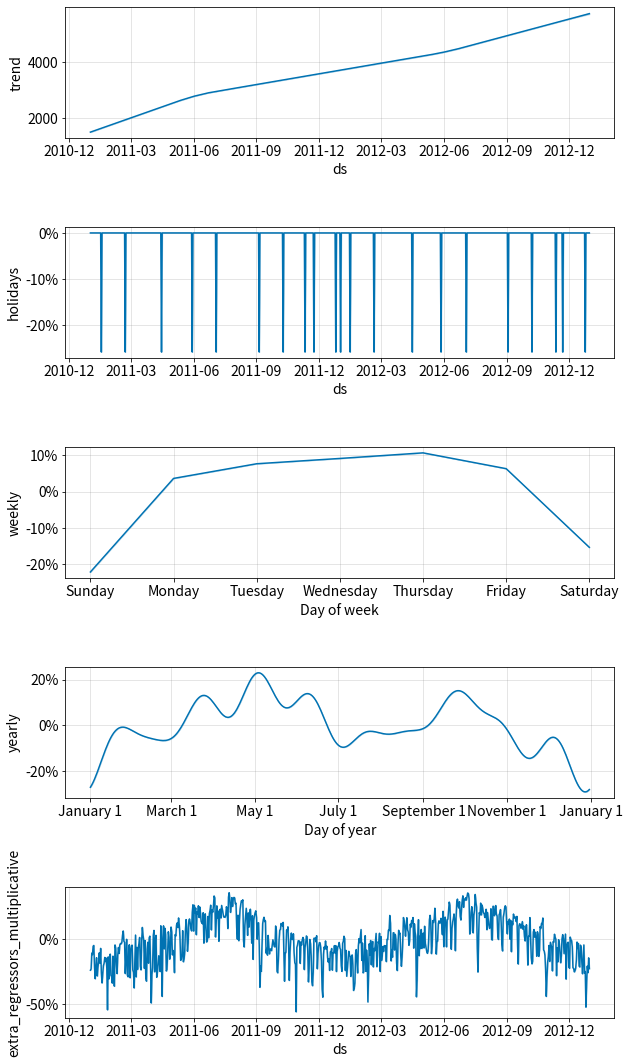

In [58]:
# 繪製各元素的圖形
fig = m3.plot_components(fcst3)
plt.show()

In [59]:
# 計算 R2 值

# 只從 fcst 中提取預測部分
ypred3 = fcst3[-61:][['yhat']].values
score3 = r2_score(ytest1, ypred3)

# 確認結果
r2_text3 = f'R2 score:{score3:.4f}'
print(r2_text3)

R2 score:0.6202


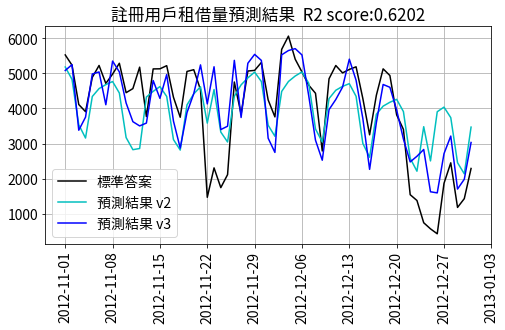

In [60]:
# 繪製時間序列圖
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 4))

# 繪製圖形
ax.plot(dates_test, ytest1, label='標準答案', c='k')
ax.plot(dates_test, ypred2, label='預測結果 v2', c='c')
ax.plot(dates_test, ypred3, label='預測結果 v3', c='b')

# 日期刻度間隔
# 於每週四顯示日期
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 將日期刻度標籤文字旋轉 90 度
ax.tick_params(axis='x', rotation=90)

# 顯示網格等
ax.grid()
ax.legend()
ax.set_title('註冊用戶租借量預測結果  ' + r2_text3)

# 輸出畫面
plt.show()

### 專欄　利用「冰淇淋消費預測」進行時間序列分析

#### 原始資料

冰淇淋調查報告アイスクリーム調査報告書  
https://www.icecream.or.jp/biz/data/expenditures.html

以下的 EXCEL 是以本報告內容為基礎，提取資料建立而成。

In [61]:
# 載入資料
url2 = 'https://github.com/makaishi2/\
sample-data/blob/master/data/ice-sales.xlsx?raw=true'

df = pd.read_excel(url2, sheet_name=0)

In [62]:
# 確認資料
display(df.head())
display(df.tail())

,年月,支出
0,2015-01-01,401
1,2015-02-01,345
2,2015-03-01,480
3,2015-04-01,590
4,2015-05-01,928


,年月,支出
55,2019-08-01,1513
56,2019-09-01,996
57,2019-10-01,724
58,2019-11-01,531
59,2019-12-01,584


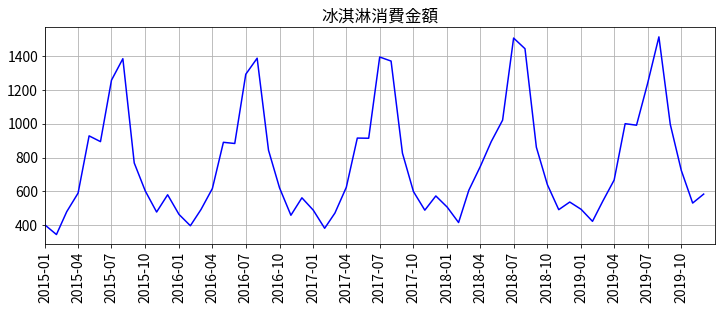

In [63]:
# 繪製時間序列圖（冰淇淋消費金額）
fig, ax = plt.subplots(figsize=(12, 4))

# 繪製圖形
ax.plot(df['年月'], df['支出'],c='b')

# 設定刻度間隔為 3 個月
month3 = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(month3)

# 將日期刻度標籤文字旋轉 90 度
ax.tick_params(axis='x', rotation=90)

# 開始日與結束日
sday = pd.to_datetime('2015-1-1')
eday = pd.to_datetime('2019-12-31')
ax.set_xlim(sday, eday) 

# 顯示網格等
ax.grid()
ax.set_title('冰淇淋消費金額')

# 輸出畫面
plt.show()

In [64]:
# 預處理資料
# 將資料轉換成適用於 Prophet 的格式
x = df.copy()
x.columns = ['ds', 'y']
display(x.head())

,ds,y
0,2015-01-01,401
1,2015-02-01,345
2,2015-03-01,480
3,2015-04-01,590
4,2015-05-01,928


In [65]:
# 分割資料
# 以2019年1月為基準分割訓練資料與驗證資料
# 設定分割日 mday
mday = pd.to_datetime('2019-1-1')

# 建立訓練用 index 與驗證用 index
train_index = x['ds'] < mday
test_index = x['ds'] >= mday

# 分割輸入資料
x_train = x[train_index]
x_test = x[test_index]

# 日期行也進行分割以便繪製圖形
dates_train = x['ds'][train_index]
dates_test = x['ds'][test_index]

In [66]:
# 選擇演算法
# 匯入套件
from fbprophet import Prophet
m = Prophet(yearly_seasonality=5, weekly_seasonality=False, daily_seasonality=False)

In [67]:
# 訓練
m = m.fit(x_train)

In [68]:
# 預測
future = x[['ds']]
fcst = m.predict(future)

In [69]:
# 評估

# 只從 fcst 中提取預測部分
ypred = fcst[-12:]['yhat'].values

# 標準答案列表
ytest = x_test['y'].values

# 計算 R2 値
from sklearn.metrics import r2_score
score = r2_score(ytest, ypred)
score_text = f'R2 score:{score:.4f}'
print(score_text)

R2 score:0.9566


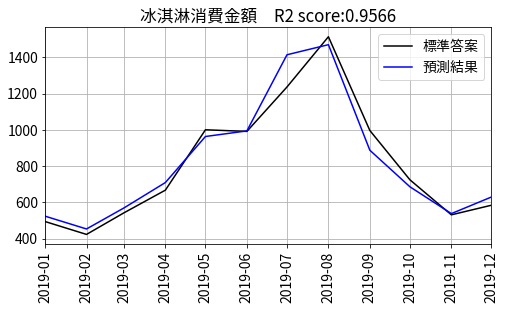

In [70]:
# 繪製時間序列圖（冰淇淋消費金額）
fig, ax = plt.subplots(figsize=(8, 4))

# 繪製圖形
ax.plot(dates_test, ytest, label='標準答案', c='k')
ax.plot(dates_test, ypred, label='預測結果', c='b')

# 設定刻度間隔為 1 個月
month = mdates.MonthLocator()
ax.xaxis.set_major_locator(month)

# 將日期刻度標籤文字旋轉 90 度
ax.tick_params(axis='x', rotation=90)

# 開始日與結束日
sday = pd.to_datetime('2019-1-1')
eday = pd.to_datetime('2019-12-1')
ax.set_xlim(sday, eday) 

# 顯示網格等
ax.grid()
ax.legend()
ax.set_title('冰淇淋消費金額　' + score_text)

# 輸出畫面
plt.show()